# Decision Trees

Het standaardvoorbeeld van de iris dataset kan ook worden opgelost met een decision tree.

In [1]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42) # max depth is belangrijk
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [3]:
# deze functie kan je gebruiken als je een boomstructuur wil opslaan als .dot file
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree.dot"),
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Om de file op te slaan in een ander formaat, is er deze command-line instructie:

In [4]:
# extra code om .dot om te zetten naar png file.
!dot -Tpng {IMAGES_PATH / "iris_tree.dot"} -o {IMAGES_PATH / "iris_tree.png"}

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Format: "png" not recognized. Use one of: bmp canon cmap cmapx cmapx_np dot dot_json eps fig gd gd2 gif gv ico imap imap_np ismap jpe jpeg jpg json json0 mp pdf pic plain plain-ext png pov ps ps2 svg svgz tif tiff tk vdx vml vmlz vrml wbmp webp xdot xdot1.2 xdot1.4 xdot_json


## Voorspellingen maken

Een decision tree is een manier van onderverdelen die per knoop een afsplitsing maakt voor 1 welbepaalde feature. Daardoor wordt de ruimte van alle mogelijke datapunten opgedeeld in rechthoekige onderverdelingen.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

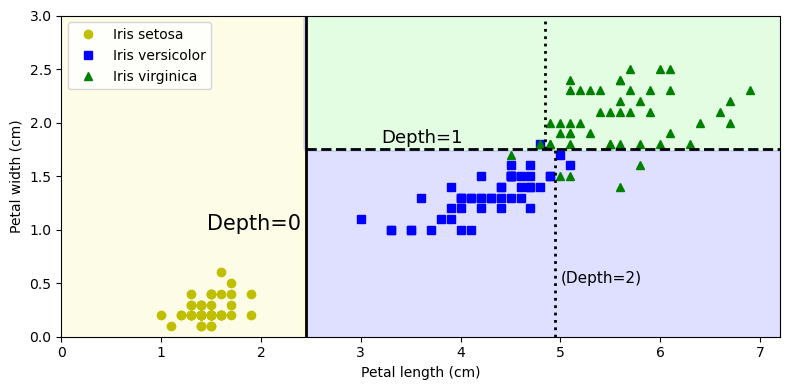

In [6]:
# extra code – just formatting details
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)

#plotten van de randen
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

#plotten van de punten in de juiste kleur
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

#1 niveau dieper
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)

# extra code – this section beautifies and saves Figure 6–2
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_decision_boundaries_plot")

plt.show()


In [7]:
tree_clf.tree_

Je kan ook de kans bepalen dat een bepaald item in een bepaalde klasse zit. Hiervoor daal je af in de decision tree tot het punt waar een item thuishoort, en vervolgens bereken je hoeveel traingsitems van klasse k er precies zijn in die node. Maw, visueel kijk je in welke box je uitkomt en schat je dan in welke klasses er daar procentueel voorkomen, en basis daarvan maak je aan voorspelling door het item te nemen met de hoogste kans.

In [8]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [9]:
tree_clf.predict([[5, 1.5]])

array([1])

### Hoe wordt een decision tree opgesteld ?

Een beslissingboom wordt opgesteld volgens het *Classification and Regression Tree* algoritme (CART). Het algoritme splits de dataset eerst op in 2 subsets via 1 bepaalde feature (*k*) en een randwaarde op die feature (*s_k*). De beslissingsboom kiest zodanig, dat de twee subsets die op die manier ontstaan *zo zuiver mogelijk* zijn. Informeel bedoelen we hiermee dat er zo weinig mogelijk klasses gemengd zijn, m.a.w. de classifier moet zo hard mogelijk zijn best doen om klasses te scheiden. 

Exacter wordt (on)zuiverheid uitgerekend met de zogenaamde *Gini impurity factor*:

$$ G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2 $$

Hierbij bedoelen we voor een blad telkens met $p_{i,k}$ de respectievelijke kansen op klasses. Voor bijvoorbeeld de depth-2 node links zien we 1 - (0/54)² - (49/54)² - (5/54)² = 0.168.

Het CART algoritme heeft dan volgende kostfunctie die ze bij elke stap wil minimaliseren:

$$ J(k, t_k) = \frac{m_{left}}{m}G_{left} + \frac{m_{right}}{m}G_{right} $$ 

Hierbij is $G_{left}$ de Gini impurity van de ene kant en $m_{left}$ het aantal data-items in die subset.

Het algoritme zoekt bij elke stap naar de beste optie *op dat ogenblik*. Dit noemen we een *greedy algorithm*. Het kan best dat er bepaalde verdelingen zouden zijn die *globaal* betere scores opleveren, omdat dieper in de boom minder optimale keuzes moeten worden genomen als gevolg van een keuze in het begin. Dit is voor een individuele beslissingsboom niet te vermijden, en daarom in de oplossing vaak 'redelijk goed', maar niet per se optimaal!

### Hyperparameters van een decision tree

Er zijn geen assumpties die een decision tree oplegt aan de data. Een decision tree zal dus altijd na verloop van tijd de data beginnen de fitten, met risico op overfitting. We noemen dit een *non-parametric model*, omdat a priori niks geweten is over de structuur van de beslissingsboom. Een lineair model heeft bijvoorbeeld wel parameters omdat je op voorhand moet aangeven hoeveel vrijheidsgraden je wil.

Omdat een beslissingsboom dus zou blijven verderzoeken, moet je met regularisatieparameters een limiet zetten op hoe ver het algoritme mag gaan. Dit zijn de *regularisatie parameters* die je kan meegeven:

- max_depth : minder diep is minder risico op overfitting
- min_samples_split : pas een split doen als er een bepaalde aantal samples zouden zijn in die split
- min_samples_leaf: minimum aantal items voor een leaf (node in de boom)
- min_weight_fraction_leaf: zelfde als hier net boven maar aangeduid als percentage
- max_leaf_nodes : totaal maximum op aantal leaves
- max_features : maximum aantal features dat gebruikt wordt voor een split op een node

Bekijk het effect op volgend voorbeeld:

In [10]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42) # hier kan je mee experimenteren!
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

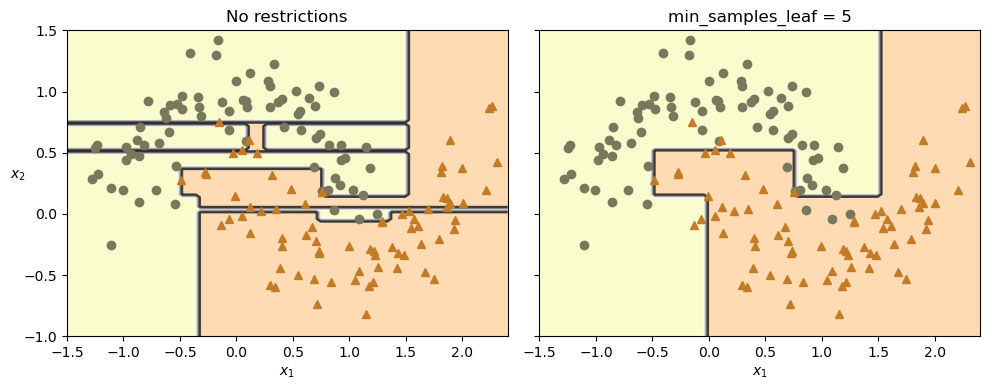

In [11]:
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
save_fig("min_samples_leaf_plot")
plt.show()

In [12]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [13]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

Het geregulariseerde model is beter!

## Regressie met Decision trees

Beschouw volgende kwadratische dataset:

In [14]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5  # a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

Hier gaan we nu een regressiemodel op loslaten:

In [15]:
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

En ook eentje met depth 3:

In [16]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

Die zien er zo uit:

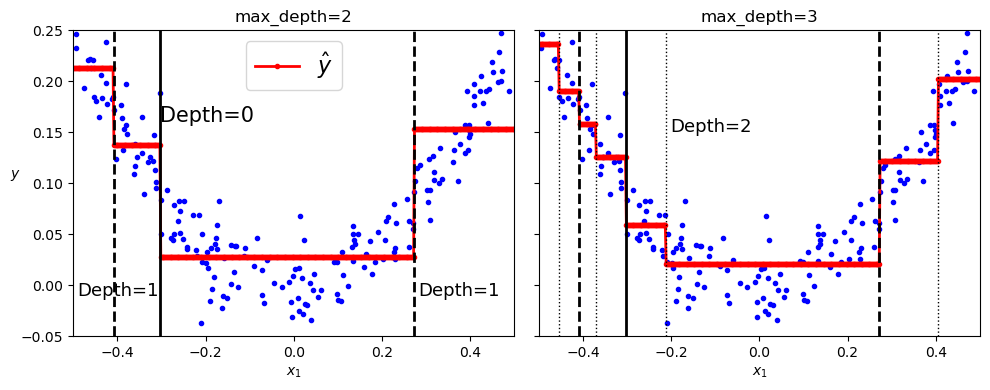

In [17]:
def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")

save_fig("tree_regression_plot")
plt.show()

Let ook hier op overfitting!

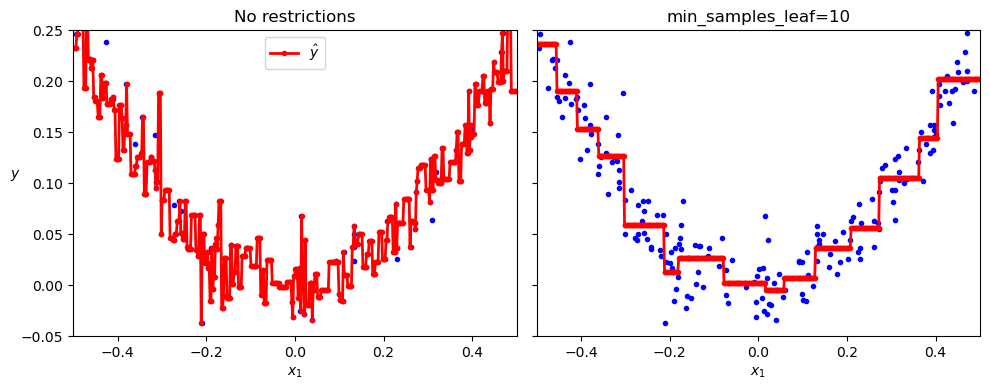

In [18]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

save_fig("tree_regression_regularization_plot")
plt.show()